<a href="https://colab.research.google.com/github/azrabano23/greengear/blob/main/ecofriendly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-9-973d5f2fbad0>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Fuel Consumption (L/100km)', 'Horsepower (HP)', 'Efficiency per HP']] = scaler.fit_transform(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        96
           1       0.57      1.00      0.73         4

    accuracy                           0.97       100
   macro avg       0.79      0.98      0.86       100
weighted avg       0.98      0.97      0.97       100

Accuracy: 0.97


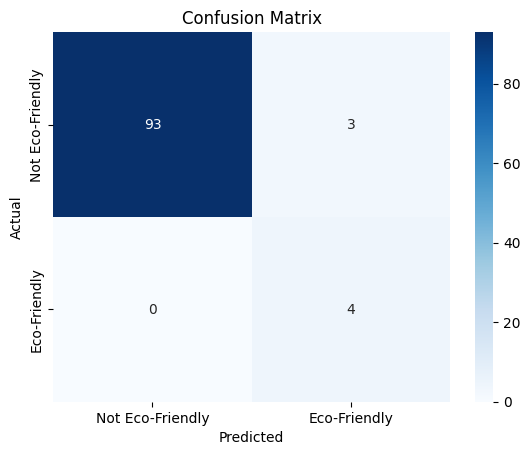

Confusion Matrix:
[[93  3]
 [ 0  4]]


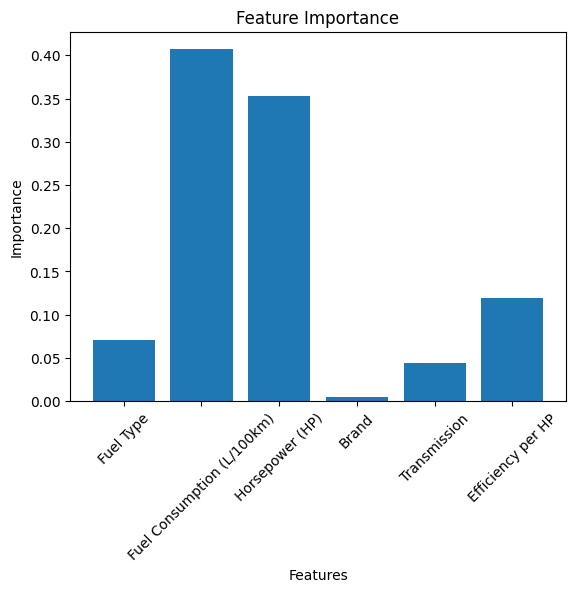

Eco-Friendly classification completed. Processed dataset saved as 'eco_friendly_cars.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

file_path = "germany_auto_industry_dataset.csv"
data = pd.read_csv(file_path)

data.columns = data.columns.str.strip()
data.rename(columns={"Price (€)": "Price"}, inplace=True)

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

data['Efficiency per HP'] = data['Fuel Consumption (L/100km)'] / (data['Horsepower (HP)'] + 1e-6)

data['Eco-Friendly'] = (
    (data['Fuel Type'].isin(['Electric', 'Hybrid'])) &
    (data['Fuel Consumption (L/100km)'] <= 5) &
    (data['Horsepower (HP)'] <= 150)
).astype(int)

label_encoders = {}
for col in ['Brand', 'Model', 'Fuel Type', 'Transmission', 'City']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data[['Fuel Type', 'Fuel Consumption (L/100km)', 'Horsepower (HP)', 'Brand', 'Transmission', 'Efficiency per HP']]
y = data['Eco-Friendly']

scaler = StandardScaler()
X[['Fuel Consumption (L/100km)', 'Horsepower (HP)', 'Efficiency per HP']] = scaler.fit_transform(
    X[['Fuel Consumption (L/100km)', 'Horsepower (HP)', 'Efficiency per HP']]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_

best_model.fit(X_train_resampled, y_train_resampled)
y_proba = best_model.predict_proba(X_test)[:, 1]

threshold = 0.3
y_pred_adjusted = (y_proba >= threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.2f}")

cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Not Eco-Friendly', 'Eco-Friendly'],
            yticklabels=['Not Eco-Friendly', 'Eco-Friendly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Confusion Matrix:")
print(cm)

plt.bar(X.columns, best_model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

joblib.dump(best_model, 'eco_friendly_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

data['Eco-Friendly Prediction'] = best_model.predict(X)

data['Reason'] = data.apply(lambda row: 'Meets all criteria' if row['Eco-Friendly'] == 1 else 'Does not meet one or more criteria', axis=1)

data.to_csv('eco_friendly_cars.csv', index=False)

print("Eco-Friendly classification completed. Processed dataset saved as 'eco_friendly_cars.csv'.")


In [ ]:
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']